# module5-2.ipynb — Step‑by‑Step Build of `MnistData`

This notebook **first implements and tests each function in cells**, then wraps them into a `MnistData` class, then **writes** `mnist_data.py` and `module5-2.py`.


## 1) Softmax and overflow‑safe softmax, with examples

In [1]:

import numpy as np

# Softmax: converts scores to probabilities that sum to 1
def softmax(x):
    x = np.asarray(x)
    if x.ndim == 1:
        ex = np.exp(x)
        return ex / np.sum(ex)
    else:
        ex = np.exp(x)
        return ex / np.sum(ex, axis=1, keepdims=True)

# Stable softmax: subtracts max to avoid overflow/underflow
def stable_softmax(x):
    x = np.asarray(x)
    if x.ndim == 1:
# Shift scores by max to keep exp() in a safe numeric range
        m = np.max(x)
        ex = np.exp(x - m)      # shift by max to prevent overflow
        return ex / np.sum(ex)
    else:
# Shift scores by max to keep exp() in a safe numeric range
        m = np.max(x, axis=1, keepdims=True)
        ex = np.exp(x - m)
        return ex / np.sum(ex, axis=1, keepdims=True)

# Examples
a = np.array([1.0, 2.0, 3.0])
print("softmax([1,2,3])       =", softmax(a))
print("stable_softmax([1,2,3])=", stable_softmax(a))

# Overflow stress test
big = np.array([1000.0, 1001.0, 999.0])
print("stable_softmax(big) works:", stable_softmax(big))
try:
    print("softmax(big) may overflow:", softmax(big))
except OverflowError as e:
    print("softmax(big) overflowed:", e)

softmax([1,2,3])       = [0.09003057 0.24472847 0.66524096]
stable_softmax([1,2,3])= [0.09003057 0.24472847 0.66524096]
stable_softmax(big) works: [0.24472847 0.66524096 0.09003057]
softmax(big) may overflow: [nan nan nan]


C:\Users\Sobhi\AppData\Local\Temp\ipykernel_16652\940727880.py:7: RuntimeWarning: overflow encountered in exp
  ex = np.exp(x)
C:\Users\Sobhi\AppData\Local\Temp\ipykernel_16652\940727880.py:8: RuntimeWarning: invalid value encountered in divide
  return ex / np.sum(ex)


In [2]:
import numpy as np

def stable_softmax(x, axis=-1):
    """
    Numerically stable softmax.
    - Works for 1D or ND arrays (default normalize over last axis).
    - Avoids overflow by subtracting the per-row max before exp.
    """
    x = np.asarray(x, dtype=np.float64)  # higher precision helps
    # subtract max for numerical stability
    m = np.max(x, axis=axis, keepdims=True)
    shifted = x - m
    ex = np.exp(shifted)
    denom = np.sum(ex, axis=axis, keepdims=True)
    # In pathological cases denom could be 0; clip to avoid NaN
    denom = np.clip(denom, a_min=np.finfo(ex.dtype).tiny, a_max=None)
    out = ex / denom
    # if input was 1D and axis=-1, return 1D
    if out.ndim == 2 and axis == -1 and x.ndim == 1:
        return out[0]
    return out


In [45]:
a = np.array([1.0, 2.0, 3.0])
print("stable_softmax([1,2,3]) =", stable_softmax(a))

big = np.array([1000.0, 1001.0, 999.0])
print("stable_softmax(big) =", stable_softmax(big))

mat = np.array([[1.0, 2.0, 3.0],
                [1000.0, 1001.0, 999.0]])
print("stable_softmax(matrix) =\n", stable_softmax(mat))   # row-wise by default (axis=-1)


stable_softmax([1,2,3]) = [0.09003057 0.24472847 0.66524096]
stable_softmax(big) = [0.24472847 0.66524096 0.09003057]
stable_softmax(matrix) =
 [[0.09003057 0.24472847 0.66524096]
 [0.24472847 0.66524096 0.09003057]]


## 2) Define `key_to_file` dictionary

In [3]:

# Mapping of logical keys to actual MNIST gzip filenames
key_to_file = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}
key_to_file

{'train_images': 'train-images-idx3-ubyte.gz',
 'train_labels': 'train-labels-idx1-ubyte.gz',
 'test_images': 't10k-images-idx3-ubyte.gz',
 'test_labels': 't10k-labels-idx1-ubyte.gz'}

## 3) `_download(filename)` and `_download_all()` (uses `key_to_file`)

In [4]:

import os, urllib.request

# Where to download MNIST gzip files from (course-hosted mirror)
url_base = "http://jrkwon.com/data/ece5831/mnist/"
# Local directory to store raw gz files and mnist.pkl cache
dataset_dir = "dataset"
mnist_pickle_name = "mnist.pkl"
os.makedirs(dataset_dir, exist_ok=True)

# Download a single gzip file if it's missing
def _download(file_name):
    """Download a single .gz file to dataset_dir, if missing."""
    dst = os.path.join(dataset_dir, file_name)
    if os.path.exists(dst):
        print("Already exists:", dst)
        return dst
    # 406 workaround
# Add empty Accept header to avoid HTTP 406 responses on some hosts
    opener = urllib.request.build_opener()
    opener.addheaders = [("Accept", "")]
    urllib.request.install_opener(opener)

    url = url_base + file_name
    print("Downloading:", url)
    urllib.request.urlretrieve(url, dst)
    print("  ->", dst)
    return dst

# Iterate over key_to_file and download everything
        # Use key_to_file mapping to fetch each gzip file
def _download_all():
    for k, fname in key_to_file.items():
        _download(fname)

print("Ready to download.")
_download_all()

Ready to download.
Already exists: dataset\train-images-idx3-ubyte.gz
Already exists: dataset\train-labels-idx1-ubyte.gz
Already exists: dataset\t10k-images-idx3-ubyte.gz
Already exists: dataset\t10k-labels-idx1-ubyte.gz


## 4) `_load_images(file_path)` and `_load_labels(file_path)`

In [19]:

import gzip
import numpy as np

IMG_SIZE = 28 * 28

# Read IDX label file: skip 8-byte header, return shape (N,)
def _load_labels(file_path):
    """Parse labels from IDX1-ubyte.gz (skip 8-byte header)."""
# Open gzip file in binary mode and read raw bytes
    with gzip.open(file_path, "rb") as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data  # (N,)

# Read IDX image file: skip 16-byte header, reshape to (N, 784)
def _load_images(file_path):
    """Parse images from IDX3-ubyte.gz (skip 16-byte header) -> (N,784) uint8."""
# Open gzip file in binary mode and read raw bytes
    with gzip.open(file_path, "rb") as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, IMG_SIZE)

## 5) Display a sample image and label to verify parsing

running show_one_example() to display a training sample.
train_images: (60000, 784) uint8 train_labels: (60000,) uint8


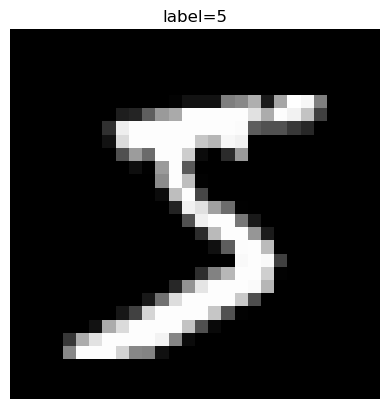

In [20]:

import matplotlib.pyplot as plt

# Helper: build absolute paths for all four gz files
def _paths():
    return {k: os.path.join(dataset_dir, v) for k, v in key_to_file.items()}

# Quick visual check that parsing worked (display first train image/label)
def show_one_example():
    paths = _paths()
    # Expect files to exist (download first)
    x_train = _load_images(paths["train_images"])
    y_train = _load_labels(paths["train_labels"])
    print("train_images:", x_train.shape, x_train.dtype, "train_labels:", y_train.shape, y_train.dtype)
# Render the 28x28 digit for quick inspection
    plt.imshow(x_train[0].reshape(28,28), cmap="gray")
    plt.title(f"label={int(y_train[0])}"); plt.axis("off"); plt.show()

print("running show_one_example() to display a training sample.")

show_one_example()

## 6) `_make_dataset()` (creates/loads `mnist.pkl`) and 7) `get_dataset()`

In [23]:
import pickle

def to_one_hot(labels: np.ndarray, num_classes: int = 10) -> np.ndarray:
    """Convert integer labels to one-hot (N, num_classes)."""
    labels = np.asarray(labels, dtype=np.int64).ravel()
    out = np.zeros((labels.size, num_classes), dtype=np.float32)
    out[np.arange(labels.size), labels] = 1.0
    return out

def _convert_numpy() -> dict:
    """Load all four gz files into a dict of NumPy arrays."""
    paths = _paths()
    d = {
        "train_images": _load_images(paths["train_images"]),
        "train_labels": _load_labels(paths["train_labels"]),
        "test_images":  _load_images(paths["test_images"]),
        "test_labels":  _load_labels(paths["test_labels"]),
    }
    return d

def _make_dataset(normalize=True, one_hot=False, num_classes=10) -> dict:
    """Create or load dataset/mnist.pkl; apply normalize and one_hot if requested."""
    pkl_path = os.path.join(dataset_dir, mnist_pickle_name)
    if os.path.exists(pkl_path):
        with open(pkl_path, "rb") as f:
            d = pickle.load(f)
    else:
        d = _convert_numpy()
        with open(pkl_path, "wb") as f:
            pickle.dump(d, f)

    # Normalize [0..255] -> [0..1]
    if normalize:
        d["train_images"] = d["train_images"].astype(np.float32) / 255.0
        d["test_images"]  = d["test_images"].astype(np.float32) / 255.0

    # Optional one-hot labels
    if one_hot:
        d["train_labels"] = to_one_hot(d["train_labels"], num_classes)
        d["test_labels"]  = to_one_hot(d["test_labels"],  num_classes)

    return d

def get_dataset(normalize=True, one_hot=False, num_classes=10):
    """Return ((x_train,y_train),(x_test,y_test)) tuples."""
    d = _make_dataset(normalize=normalize, one_hot=one_hot, num_classes=num_classes)
    return (d["train_images"], d["train_labels"]), (d["test_images"], d["test_labels"])

print("After _download_all(), run get_dataset(normalize=True, one_hot=False).")
# (x_train, y_train), (x_test, y_test) = get_dataset(normalize=True, one_hot=False)
# print(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype)
# print(x_test.shape, x_test.dtype, y_test.shape, y_test.dtype)


After _download_all(), run get_dataset(normalize=True, one_hot=False).


## 8) `to_one_hot(labels, num_classes=10)` with example

In [24]:

# Convert integer labels (0..9) to one-hot vectors of length 10
def to_one_hot(labels, num_classes=10):
    labels = np.asarray(labels, dtype=np.int64).ravel()
    out = np.zeros((labels.size, num_classes), dtype=np.float32)
    out[np.arange(labels.size), labels] = 1.0
    return out

# Demo:
demo = np.array([0, 3, 9, 1])
print("labels:", demo.tolist())
print("one-hot:\n", to_one_hot(demo, 10))

labels: [0, 3, 9, 1]
one-hot:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---
## 9) Create **MnistData** class (convert the tested functions into methods)
**__init__** should call `_download_all()` and `_make_dataset()` and keep dataset as a member.

In [25]:

# Class wrapper that calls download+make_dataset on construction
class MnistData:
# Where to download MNIST gzip files from (course-hosted mirror)
    url_base = url_base
# Mapping of logical keys to actual MNIST gzip filenames
    key_to_file = key_to_file
# Local directory to store raw gz files and mnist.pkl cache
    dataset_dir = dataset_dir
    mnist_pickle_name = mnist_pickle_name
    img_size = 28 * 28
    num_classes = 10

        # Ensure data dir exists, download files, then build/load dataset
    def __init__(self, root=".", normalize=True, one_hot=False):
        import os
        self.root = os.path.abspath(root)
        self.normalize = normalize
        self.one_hot = one_hot

        os.makedirs(os.path.join(self.root, self.dataset_dir), exist_ok=True)
        self._download_all()
        self.dataset = self._make_dataset()

    def _gz(self, fname):  # helper path joiner
        return os.path.join(self.root, self.dataset_dir, fname)

# Download a single gzip file if it's missing
    def _download(self, file_name):
        dst = self._gz(file_name)
        if os.path.exists(dst):
            return dst
# Add empty Accept header to avoid HTTP 406 responses on some hosts
        opener = urllib.request.build_opener()
        opener.addheaders = [("Accept", "")]
        urllib.request.install_opener(opener)
        url = self.url_base + file_name
        print("Downloading:", url)
        urllib.request.urlretrieve(url, dst)
        print("  ->", dst)
        return dst

# Iterate over key_to_file and download everything
        # Use key_to_file mapping to fetch each gzip file
    def _download_all(self):
        for k, fname in self.key_to_file.items():
            self._download(fname)

# Read IDX label file: skip 8-byte header, return shape (N,)
    def _load_labels(self, path):
# Open gzip file in binary mode and read raw bytes
        with gzip.open(path, "rb") as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

# Read IDX image file: skip 16-byte header, reshape to (N, 784)
    def _load_images(self, path):
# Open gzip file in binary mode and read raw bytes
        with gzip.open(path, "rb") as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, self.img_size)

# Parse all four gz files into a dict of NumPy arrays
    def _convert_numpy(self):
        d = {}
        d["train_images"] = self._load_images(self._gz(self.key_to_file["train_images"]))
        d["train_labels"] = self._load_labels(self._gz(self.key_to_file["train_labels"]))
        d["test_images"]  = self._load_images(self._gz(self.key_to_file["test_images"]))
        d["test_labels"]  = self._load_labels(self._gz(self.key_to_file["test_labels"]))
        return d

    def _pickle_path(self):
        return os.path.join(self.root, self.dataset_dir, self.mnist_pickle_name)

# Create or load mnist.pkl; apply normalize/one_hot flags
        # Cache to mnist.pkl and normalize/one-hot per settings
    def _make_dataset(self):
        pkl = self._pickle_path()
        if os.path.exists(pkl):
            import pickle
            with open(pkl, "rb") as f:
                d = pickle.load(f)
        else:
            d = self._convert_numpy()
            import pickle
            with open(pkl, "wb") as f:
                pickle.dump(d, f)

        if self.normalize:
            d["train_images"] = d["train_images"].astype(np.float32)/255.0
            d["test_images"]  = d["test_images"].astype(np.float32)/255.0

        if self.one_hot:
            d["train_labels"] = self.to_one_hot(d["train_labels"], self.num_classes)
            d["test_labels"]  = self.to_one_hot(d["test_labels"],  self.num_classes)

        return d

# Return (x_train, y_train), (x_test, y_test) tuples
        # Provide the same tuple interface used earlier in the notebook
    def get_dataset(self):
        d = self.dataset
        return (d["train_images"], d["train_labels"]), (d["test_images"], d["test_labels"])

    @staticmethod
# Convert integer labels (0..9) to one-hot vectors of length 10
    def to_one_hot(labels, num_classes=10):
        labels = np.asarray(labels, dtype=np.int64).ravel()
        out = np.zeros((labels.size, num_classes), dtype=np.float32)
        out[np.arange(labels.size), labels] = 1.0
        return out

## 10) Verify class works (show 2 train + 2 test images)

Running show_examples_with_class() to view 4 samples.


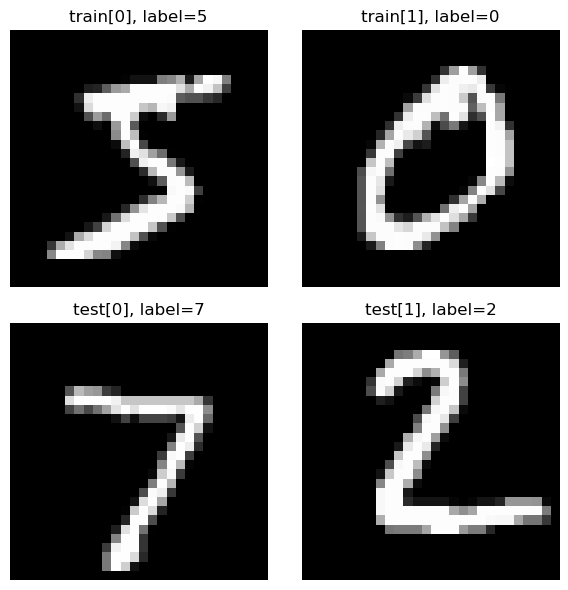

In [26]:

def show_examples_with_class():
    mnist = MnistData(root=".", normalize=True, one_hot=False)  # downloads on first run
    (x_train, y_train), (x_test, y_test) = mnist.get_dataset()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    for i, (x, y, title) in enumerate([
        (x_train[0], y_train[0], "train[0]"),
        (x_train[1], y_train[1], "train[1]"),
        (x_test[0],  y_test[0],  "test[0]"),
        (x_test[1],  y_test[1],  "test[1]")
    ]):
        plt.subplot(2,2,i+1)
# Render the 28x28 digit for quick inspection
        plt.imshow(x.reshape(28,28), cmap="gray")
        plt.title(f"{title}, label={int(y)}"); plt.axis("off")
    plt.tight_layout(); plt.show()

print("Running show_examples_with_class() to view 4 samples.")
show_examples_with_class()

## 13) Run the script from this notebook

In [27]:
# Run module5-2.py from within Jupyter Notebook (Windows PowerShell / Linux shell)
!python module5-2.py --umid3 351

Train images: (60000, 784) float32
Train labels: (60000,) uint8
Test images: (10000, 784) float32
Test labels: (10000,) uint8
softmax([1,2,3]) = [0.09003057 0.24472847 0.66524096]
stable_softmax([1,2,3]) = [0.09003057 0.24472847 0.66524096]
Figure(220x240)
Saved figure: figs\One_Train_Example.png
Figure(220x240)
Saved figure: figs\One_Test_Example.png
Figure(660x240)
Saved figure: figs\Three_Train_Images_UMID3=351.png


Train images: (60000, 784) float32
Train labels: (60000,) uint8
Test images: (10000, 784) float32
Test labels: (10000,) uint8
softmax([1,2,3]) = [0.09003057 0.24472847 0.66524096]
stable_softmax([1,2,3]) = [0.09003057 0.24472847 0.66524096]


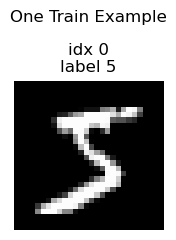

Saved figure: figs\One_Train_Example.png


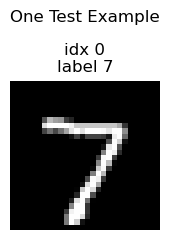

Saved figure: figs\One_Test_Example.png


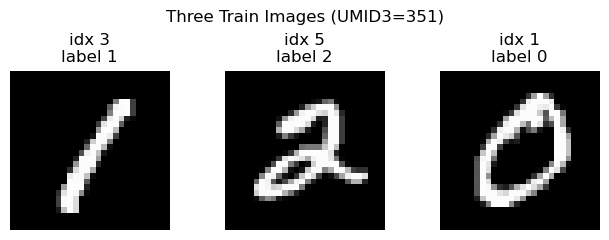

Saved figure: figs\Three_Train_Images_UMID3=351.png


In [28]:
plt.close('all')
%run module5-2.py --umid3 351


In [29]:
# Use the class to predict test images and check vs. test labels

from mnist_data import MnistData
from mnist import Mnist
import numpy as np

# 1) Load MNIST (normalized to [0,1], labels as integers)
mnist_data = MnistData(root=".", normalize=True, one_hot=False)
(x_train, y_train), (x_test, y_test) = mnist_data.get_dataset()

# 2) Initialize pretrained 3-layer MLP
#    Make sure model/sample_weight.pkl exists
clf = Mnist(model_path="model/sample_weight.pkl")

# 3) Predict a small sample and print Success/Fail per item
k = 10  # how many samples to inspect
probs = clf.predict(x_test[:k])               # (k,10)
preds = np.argmax(probs, axis=1)

for i in range(k):
    gt = int(y_test[i])
    pd = int(preds[i])
    if pd == gt:
        print(f"Success: test[{i}] is {gt} recognized as {pd}.")
    else:
        print(f"Fail:    test[{i}] is {gt} but recognized as {pd}.")

# 4) Compute overall test accuracy (batched for speed)
acc = clf.accuracy(x_test, y_test, batch_size=100)
print(f"\nOverall test accuracy: {acc:.4f}")


Success: test[0] is 7 recognized as 7.
Success: test[1] is 2 recognized as 2.
Success: test[2] is 1 recognized as 1.
Success: test[3] is 0 recognized as 0.
Success: test[4] is 4 recognized as 4.
Success: test[5] is 1 recognized as 1.
Success: test[6] is 4 recognized as 4.
Success: test[7] is 9 recognized as 9.
Fail:    test[8] is 5 but recognized as 6.
Success: test[9] is 9 recognized as 9.

Overall test accuracy: 0.9352


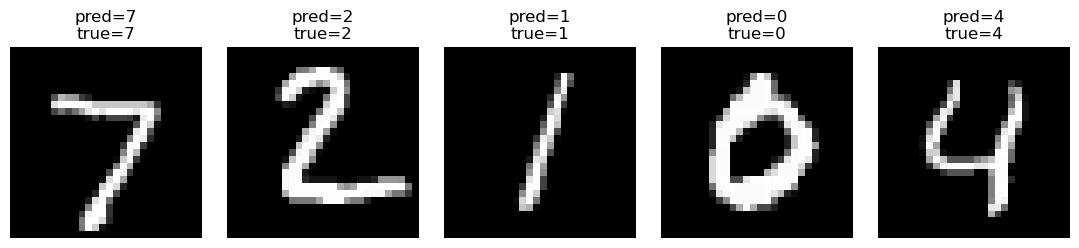

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Predict all test images (returns probabilities for each digit 0–9)
preds_all = np.argmax(clf.predict(x_test), axis=1)

# Select a few sample indices to visualize
idxs = [0, 1, 2, 3, 4]  # you can change this list to view other samples

# Create a figure with 1 row and len(idxs) columns
plt.figure(figsize=(len(idxs) * 2.2, 2.4))

# Loop through selected indices and plot each image
for i, idx in enumerate(idxs):
    # Each image is 28×28 pixels; reshape from flattened 784 array
    plt.subplot(1, len(idxs), i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    
    # Show both the predicted and true labels for comparison
    plt.title(f"pred={int(preds_all[idx])}\ntrue={int(y_test[idx])}")
    plt.axis("off")  # hide axes for a cleaner look

# Adjust layout so titles and images don’t overlap
plt.tight_layout()

# Display all plots inline in the notebook
plt.show()
